In [1]:
# Core utilities moved to fire_model package
import numpy as np
import matplotlib.pyplot as plt
from fire_model.ca import FireEnv, FireState, CAFireModel
from fire_model.boundary import (
    FireBoundary,
    between_boundaries_mask,
    candidates_from_mask,
    extract_fire_boundary,
    plot_fire_boundary,
)
from fire_model.harmonic import (
    HarmonicStripMap,
    BoundaryMap,
    build_harmonic_strip_map_uniform,
    plot_strip_map,
    sd_to_xy_theta,
    build_boundary_map,
    plot_boundary_correspondence,
)
from fire_model.bo import (
    RetardantDropBayesOpt,
    SearchGridProjector,
    TiedXYFiMatern,
    expected_improvement,
)

import fire_model.bo as bo

### Low-Fid (A bit coarse)

In [5]:
nx = ny = 120
dt_s = 5.0
n_sims = 50

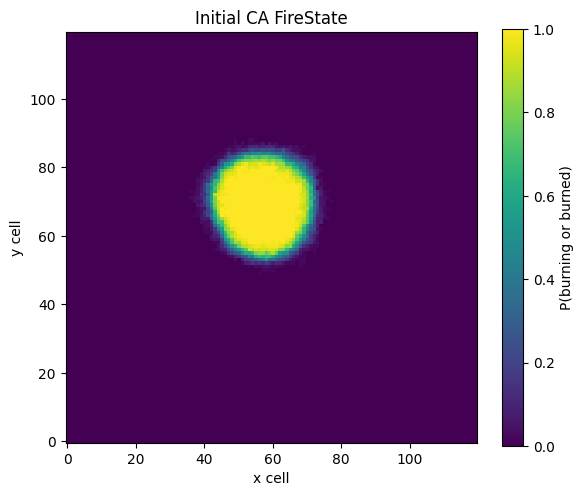

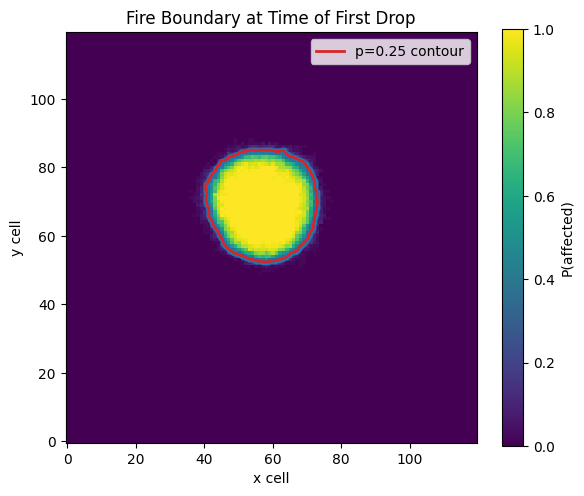

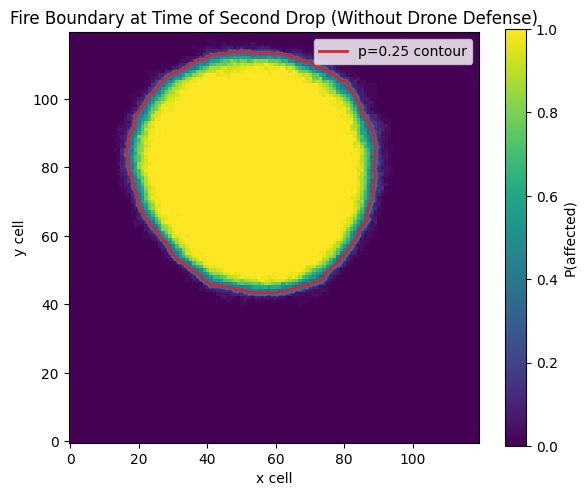

In [6]:
# Grid / domain
domain_km = 5

# Fire physics parameters
burn_time_s0 = 15 * 60         # how long a cell stays "burning" after ignition (seconds)
ros_mps = 0.25                 # baseline ROS (m/s)

# Retardant parameters
retardant_half_life_s = 2400.0 # seconds (e.g., 40 minutes)
retardant_k = 1.25             # attenuation strength exp(-k * retardant)

# Spatial maps
xs = np.linspace(-1.0, 1.0, nx)[:, None]
ys = np.linspace(-1.0, 1.0, ny)[None, :]
fuel = 0.7 + 0.9 * np.exp(-3.0 * (xs**2 + ys**2))
fuel = np.ones((nx, ny), dtype=float)
value = 1.0 + 10.0 * np.exp(-15.0 * ((xs+0.5) ** 2 + (ys - 0.25) ** 2))

# Constant wind: mild south-westerly
wind=np.zeros((nx, ny, 2), dtype=float)
wind[..., 0] = -5
wind[..., 1] = 15.0  # 5 m/s northwards

env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    wind=wind,
    fuel=fuel,
    value=value,
    dt_s=dt_s,
    burn_time_s0=burn_time_s0,
    retardant_half_life_s=retardant_half_life_s,
    retardant_k=retardant_k,
    ros_mps=ros_mps,
    # wind_coeff is unused by the Finsler model, but can exist in the env
    wind_coeff=0.6,
    diag=True,
    avoid_burning_drop=True,
    avoid_drop_p_threshold=0.25,
)

ca_model = CAFireModel(env,seed=42)

# Ignition and time until drones reach the fire
ignition_center = (nx // 2, ny // 2)
ignition_radius_km = 0.01
time_to_first_drop = 150.0  
time_to_second_drop = 310.0 #
search_space_time = (time_to_second_drop - time_to_first_drop)//2

# Initial Evolution
init_firestate_ca = ca_model.simulate_from_ignition(
    center=ignition_center,
    radius_km=ignition_radius_km,
    n_sims=n_sims,
    T=time_to_first_drop
)

ca_model.plot_firestate(init_firestate_ca,title="Initial CA FireState")

# Visualising the boundary
init_boundary = extract_fire_boundary(
    init_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    init_firestate_ca,
    init_boundary,
    field="affected",
    title="Fire Boundary at Time of First Drop"
)

# Visualising the search domain
second_firestate_ca = ca_model.simulate_from_firestate(
    init_firestate=init_firestate_ca,
    T=time_to_second_drop - time_to_first_drop, # assumes we want to search the whole space between first & second drop (smaller might be better in practice)
    n_sims=n_sims
)

second_boundary = extract_fire_boundary(
    second_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    second_firestate_ca,
    second_boundary,
    field="affected",
    title="Fire Boundary at Time of Second Drop (Without Drone Defense)"
)

### High-Fid (High granularity)

In [8]:
nx = ny = 200
dt_s = 1.0
n_sims = 200

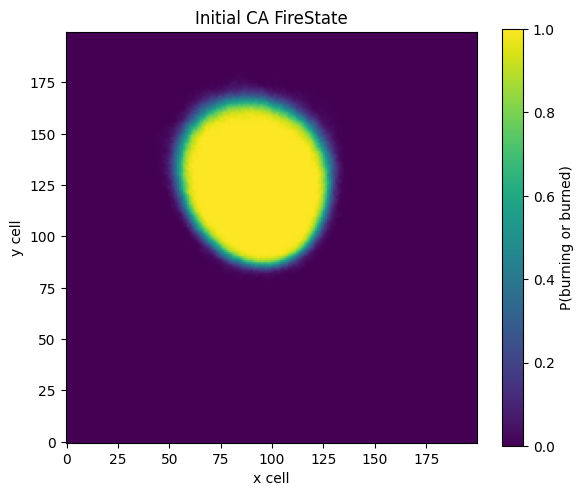

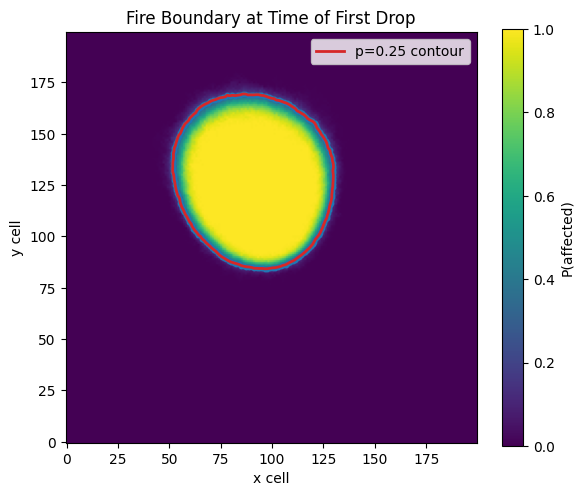

In [ ]:
# Grid / domain
domain_km = 5

# Fire physics parameters
burn_time_s0 = 15 * 60         # how long a cell stays "burning" after ignition (seconds)
ros_mps = 0.25                 # baseline ROS (m/s)

# Retardant parameters
retardant_half_life_s = 2400.0 # seconds (e.g., 40 minutes)
retardant_k = 1.25             # attenuation strength exp(-k * retardant)

# Spatial maps
xs = np.linspace(-1.0, 1.0, nx)[:, None]
ys = np.linspace(-1.0, 1.0, ny)[None, :]
fuel = 0.7 + 0.9 * np.exp(-3.0 * (xs**2 + ys**2))
fuel = np.ones((nx, ny), dtype=float)
value = 1.0 + 10.0 * np.exp(-15.0 * ((xs+0.5) ** 2 + (ys - 0.25) ** 2))

# Constant wind: mild south-westerly
wind=np.zeros((nx, ny, 2), dtype=float)
wind[..., 0] = -5
wind[..., 1] = 15.0  # 5 m/s northwards

env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    wind=wind,
    fuel=fuel,
    value=value,
    dt_s=dt_s,
    burn_time_s0=burn_time_s0,
    retardant_half_life_s=retardant_half_life_s,
    retardant_k=retardant_k,
    ros_mps=ros_mps,
    # wind_coeff is unused by the Finsler model, but can exist in the env
    wind_coeff=0.6,
    diag=True,
    avoid_burning_drop=True,
    avoid_drop_p_threshold=0.25,
)

ca_model = CAFireModel(env,seed=42)

# Ignition and time until drones reach the fire
ignition_center = (nx // 2, ny // 2)
ignition_radius_km = 0.01
time_to_first_drop = 150.0  
time_to_second_drop = 310.0 #
search_space_time = (time_to_second_drop - time_to_first_drop)//2

# Initial Evolution
init_firestate_ca = ca_model.simulate_from_ignition(
    center=ignition_center,
    radius_km=ignition_radius_km,
    n_sims=n_sims,
    T=time_to_first_drop
)

ca_model.plot_firestate(init_firestate_ca,title="Initial CA FireState")

# Visualising the boundary
init_boundary = extract_fire_boundary(
    init_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    init_firestate_ca,
    init_boundary,
    field="affected",
    title="Fire Boundary at Time of First Drop"
)

# Visualising the search domain
second_firestate_ca = ca_model.simulate_from_firestate(
    init_firestate=init_firestate_ca,
    T=time_to_second_drop - time_to_first_drop, # assumes we want to search the whole space between first & second drop (smaller might be better in practice)
    n_sims=n_sims
)

second_boundary = extract_fire_boundary(
    second_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    second_firestate_ca,
    second_boundary,
    field="affected",
    title="Fire Boundary at Time of Second Drop (Without Drone Defense)"
)

### Quick pilot: does coarse CA preserve the ranking?

Evaluate a batch of shared (physical) retardant drop plans at low vs high CA granularity, then report
rank-correlation and a simple linear fit. If Spearman is low, MFBO is unlikely to help.


In [ ]:
import time

# --- Pilot config (tune for speed vs stability) ---
seed = 0
n_points = 25          # number of shared plans to compare
n_drones = 4

# Low-fidelity
nx_low = ny_low = 120
dt_s_low = 5.0
n_sims_init_low = 40
n_sims_grid_low = 30
n_sims_eval_low = 30

# High-fidelity
nx_high = ny_high = 200
dt_s_high = 1.0
n_sims_init_high = 80
n_sims_grid_high = 50
n_sims_eval_high = 60

# Scenario (match the notebook above)
domain_km = 5.0
burn_time_s0 = 15 * 60
ros_mps = 0.25
retardant_half_life_s = 2400.0
retardant_k = 1.25

ignition_radius_km = 0.01

time_to_first_drop = 150.0
time_to_second_drop = 310.0
T_evolve = time_to_second_drop - time_to_first_drop

p_boundary = 0.25
K_boundary = 200

rng = np.random.default_rng(seed)


def _make_env(nx, ny, dt_s):
    xs = np.linspace(-1.0, 1.0, nx)[:, None]
    ys = np.linspace(-1.0, 1.0, ny)[None, :]

    fuel = np.ones((nx, ny), dtype=float)
    value = 1.0 + 10.0 * np.exp(-15.0 * ((xs + 0.5) ** 2 + (ys - 0.25) ** 2))

    wind = np.zeros((nx, ny, 2), dtype=float)
    wind[..., 0] = -5.0
    wind[..., 1] = 15.0

    return FireEnv(
        grid_size=(nx, ny),
        domain_km=domain_km,
        wind=wind,
        fuel=fuel,
        value=value,
        dt_s=dt_s,
        burn_time_s0=burn_time_s0,
        retardant_half_life_s=retardant_half_life_s,
        retardant_k=retardant_k,
        ros_mps=ros_mps,
        wind_coeff=0.6,
        diag=True,
        avoid_burning_drop=True,
        avoid_drop_p_threshold=0.25,
    )


def _build_fidelity(nx, ny, dt_s, n_sims_init, n_sims_grid):
    env = _make_env(nx, ny, dt_s)
    model = CAFireModel(env, seed=42)

    ignition_center = (nx // 2, ny // 2)
    init_firestate = model.simulate_from_ignition(
        center=ignition_center,
        radius_km=ignition_radius_km,
        n_sims=n_sims_init,
        T=time_to_first_drop,
    )

    mask, init_b, final_b, _ = model.generate_search_domain(
        T=T_evolve,
        n_sims=n_sims_grid,
        init_firestate=init_firestate,
        ros_mps=model.env.ros_mps,
        wind_coeff=model.env.wind_coeff,
        diag=model.env.diag,
        seed=None,
        p_boundary=p_boundary,
        K=K_boundary,
        boundary_field="affected",
        return_boundaries=True,
    )

    return model, init_firestate, mask, init_b, final_b


def _expected_value_burned(model, init_firestate, drone_params, n_sims_eval):
    evolved = model.simulate_from_firestate(
        init_firestate,
        T=T_evolve,
        n_sims=n_sims_eval,
        drone_params=drone_params,
        ros_mps=model.env.ros_mps,
        wind_coeff=model.env.wind_coeff,
        diag=model.env.diag,
        seed=None,
        avoid_burning_drop=model.env.avoid_burning_drop,
        burning_prob_threshold=model.env.avoid_drop_p_threshold,
    )

    p_burning = evolved.burning[0].astype(float, copy=False)
    p_burned = evolved.burned[0].astype(float, copy=False)
    p_affected = np.clip(p_burning + p_burned, 0.0, 1.0)

    nx, _ = model.env.grid_size
    dx = model.env.domain_km / nx
    return float(np.sum(p_affected * model.env.value) * (dx ** 2))


def _rankdata_average(x: np.ndarray) -> np.ndarray:
    x = np.asarray(x)
    n = x.size
    if n == 0:
        return x.astype(float)

    sorter = np.argsort(x, kind="mergesort")
    inv = np.empty_like(sorter)
    inv[sorter] = np.arange(n)

    xs = x[sorter]
    ranks = np.empty(n, dtype=float)

    i = 0
    while i < n:
        j = i
        while j + 1 < n and xs[j + 1] == xs[i]:
            j += 1
        ranks[i : j + 1] = 0.5 * (i + j) + 1.0
        i = j + 1

    return ranks[inv]


def _spearmanr(x: np.ndarray, y: np.ndarray) -> float:
    rx = _rankdata_average(x)
    ry = _rankdata_average(y)
    c = np.corrcoef(rx, ry)
    return float(c[0, 1])


print('Building low/high fidelities...')
model_low, init_low, mask_low, b0_low, b1_low = _build_fidelity(
    nx_low, ny_low, dt_s_low, n_sims_init_low, n_sims_grid_low
)
model_high, init_high, mask_high, b0_high, b1_high = _build_fidelity(
    nx_high, ny_high, dt_s_high, n_sims_init_high, n_sims_grid_high
)

dx_low = model_low.env.domain_km / nx_low
dx_high = model_high.env.domain_km / nx_high

coords_low = np.argwhere(mask_low)
if coords_low.size == 0:
    raise RuntimeError('Low-fidelity search mask is empty; try lowering p_boundary or K_boundary.')


def _sample_shared_physical_plan(max_tries=2000):
    for _ in range(max_tries):
        idx = rng.integers(0, len(coords_low), size=n_drones)
        xy_low_cells = coords_low[idx].astype(float)
        phi = rng.uniform(0.0, 2.0 * np.pi, size=n_drones)

        # Represent plan in physical coords (km) + phi, so we can evaluate it on either grid.
        xy_km = xy_low_cells * dx_low
        plan_km = np.column_stack([xy_km, phi])

        # Require that the mapped points land inside the high-fidelity search mask too.
        xy_high_cells = np.rint(xy_km / dx_high).astype(int)
        xh = np.clip(xy_high_cells[:, 0], 0, nx_high - 1)
        yh = np.clip(xy_high_cells[:, 1], 0, ny_high - 1)

        if np.all(mask_high[xh, yh]):
            return plan_km

    raise RuntimeError('Could not find shared plans inside both search masks; increase max_tries or relax boundary params.')


def _plan_to_drone_params(plan_km, dx):
    plan_km = np.asarray(plan_km, dtype=float)
    out = plan_km.copy()
    out[:, 0] = plan_km[:, 0] / dx
    out[:, 1] = plan_km[:, 1] / dx
    return out


plans_km = [_sample_shared_physical_plan() for _ in range(n_points)]

# Evaluate
print(f'Evaluating {n_points} shared plans...')
y_low = np.empty(n_points, dtype=float)
y_high = np.empty(n_points, dtype=float)

t_low = []
t_high = []

for i, plan_km in enumerate(plans_km):
    dp_low = _plan_to_drone_params(plan_km, dx_low)
    dp_high = _plan_to_drone_params(plan_km, dx_high)

    t0 = time.perf_counter()
    y_low[i] = _expected_value_burned(model_low, init_low, dp_low, n_sims_eval_low)
    t_low.append(time.perf_counter() - t0)

    t0 = time.perf_counter()
    y_high[i] = _expected_value_burned(model_high, init_high, dp_high, n_sims_eval_high)
    t_high.append(time.perf_counter() - t0)

rho_s = _spearmanr(y_low, y_high)
rho_p = float(np.corrcoef(y_low, y_high)[0, 1])

# Simple linear fit: y_high ~= a*y_low + b
A = np.vstack([y_low, np.ones_like(y_low)]).T
coef, *_ = np.linalg.lstsq(A, y_high, rcond=None)
a, b = float(coef[0]), float(coef[1])
y_hat = a * y_low + b
ss_res = float(np.sum((y_high - y_hat) ** 2))
ss_tot = float(np.sum((y_high - float(np.mean(y_high))) ** 2))
r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else float('nan')

mean_low = float(np.mean(t_low))
mean_high = float(np.mean(t_high))
cost_ratio = mean_high / mean_low if mean_low > 0 else float('inf')

print('\n--- Pilot summary ---')
print(f'Spearman rank corr: {rho_s:.3f}')
print(f'Pearson corr:       {rho_p:.3f}')
print(f'Linear fit:         y_high ≈ {a:.3g} * y_low + {b:.3g}  (R²={r2:.3f})')
print(f'Mean eval time:     low={mean_low:.3f}s | high={mean_high:.3f}s | ratio={cost_ratio:.1f}×')

plt.figure(figsize=(5.5, 4.5))
plt.scatter(y_low, y_high, alpha=0.8)
xs = np.linspace(float(np.min(y_low)), float(np.max(y_low)), 100)
plt.plot(xs, a * xs + b, color='k', linewidth=2, label='fit')
plt.xlabel('Low-fidelity objective')
plt.ylabel('High-fidelity objective')
plt.title(f'Low vs high fidelity\nSpearman={rho_s:.2f} | Pearson={rho_p:.2f} | cost≈{cost_ratio:.1f}×')
plt.grid(True, alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()
